## Fine Tuning Xception for ICB

In [1]:
import gc
import lib
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras as kr
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import itertools

%matplotlib inline

[01:26:00] Library functions loaded.


In [2]:
# Implementation Dependant Globals
REQUIRED_DIMENSIONS = (299, 299)
TRAIN_BATCH_SIZE = 10
VALIDATION_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

# Import dataset
%run DataPreparation.ipynb 

[01:26:01] Data preparation started.
[01:26:01] Loaded custom functions.
(SKIPPED) Found a non image file:  ./dataset/validation/non_biomass/metal282 - Shortcut.lnk
[Non Processed Classifier Input Data]
Raw pixels matrix: 242.01MB
Raw features matrix: 1.85MB
[01:26:11] Loaded raw congregates of images, features and labels.
[Non Augmented Generators]
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[Augmented Generators]
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[01:26:11] Loaded all generators.
[Total Info]
Number of images: 924
Size of images: 0.01MB
[01:26:11] Data preperation completed!
Time taken: 10.725600242614746 seconds.


#### Fetch & Download Xception model

In [3]:
xception = kr.applications.xception
xception_model = xception.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=REQUIRED_DIMENSIONS+(3,)
)

xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

#### Building and Compiling

In [4]:
# Ease of Access
GlobalAveragePooling2D, Model, Dropout, Flatten, Dense = kr.layers.GlobalAveragePooling2D, kr.models.Model, kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

# Construct the Head Model
head_model = xception_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(200,activation='relu')(head_model)
head_model = Dropout(0.4)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# place the head model on top of the base model (this will become the actual model we will train)
model = Model(inputs=xception_model.input, outputs=head_model)

# Freeze all the layers
for layer in xception_model.layers:
    layer.trainable = False

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

block6_sepconv1 (SeparableConv2 (None, 19, 19, 728)  536536      block6_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block6_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block6_sepconv1[0][0]            
__________________________________________________________________________________________________
block6_sepconv2_act (Activation (None, 19, 19, 728)  0           block6_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block6_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block6_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block6_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block6_sepconv2[0][0]            
__________________________________________________________________________________________________
block6_sep

#### Warmup Training

In [5]:
# Pls memory
gc.collect()

# Compile Model
model.compile(
    loss='binary_crossentropy',
    optimizer=kr.optimizers.Nadam(lr=0.0001),
    metrics=['accuracy']
)

# Train the head of the model(Our Layers)
warmup_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True
)

warmup_history.plot_title = "Warmup"

Epoch 1/30
50/49 [==============================] - 39s 784ms/step - loss: 0.7395 - accuracy: 0.4980 - val_loss: 3.8031 - val_accuracy: 0.5775
Epoch 2/30
50/49 [==============================] - 37s 745ms/step - loss: 0.7311 - accuracy: 0.4859 - val_loss: 6.7623 - val_accuracy: 0.4296
Epoch 3/30
50/49 [==============================] - 37s 743ms/step - loss: 0.7149 - accuracy: 0.5262 - val_loss: 5.0532 - val_accuracy: 0.4648
Epoch 4/30
50/49 [==============================] - 40s 800ms/step - loss: 0.6910 - accuracy: 0.5665 - val_loss: 6.0586 - val_accuracy: 0.4331
Epoch 5/30
50/49 [==============================] - 49s 982ms/step - loss: 0.6603 - accuracy: 0.6270 - val_loss: 5.5066 - val_accuracy: 0.4507
Epoch 6/30
50/49 [==============================] - 43s 865ms/step - loss: 0.6485 - accuracy: 0.6331 - val_loss: 4.5550 - val_accuracy: 0.4894
Epoch 7/30
50/49 [==============================] - 37s 737ms/step - loss: 0.6340 - accuracy: 0.6613 - val_loss: 3.8554 - val_accuracy: 0.5176

14/14 [==============================] - 3s 241ms/step
              precision    recall  f1-score   support

     biomass       0.49      0.64      0.56        70
 non_biomass       0.48      0.33      0.39        70

    accuracy                           0.49       140
   macro avg       0.48      0.49      0.47       140
weighted avg       0.48      0.49      0.47       140

Normalized confusion matrix


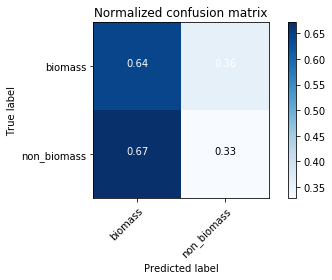

In [6]:
# Make predictions
predictions = model.predict_generator(test_set, steps=test_set.samples/test_set.batch_size, verbose=1)
normalised_predictions = np.argmax(predictions, axis=1)

# Print out scikit report
print(classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))

# Draw confusion matrix
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

#### Final Training

In [7]:
# Reset validaiton & train set generators
train_set.reset()
validation_set.reset()

# Now that the head FC layers have been trained/initialized, lets
# Unfreeze the final set of CONV layers and make them trainable
for layer in xception_model.layers:
	layer.trainable = True

    
# Recompile model for changes to take effect, now using SGD with very small learning rate
model.compile(
    loss="binary_crossentropy", 
    optimizer="nadam", 
    metrics=["accuracy"]
)    

# Train the whole model
final_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True
)

final_history.plot_title = "Final"

Epoch 1/30
50/49 [==============================] - 57s 1s/step - loss: 0.6192 - accuracy: 0.7661 - val_loss: 1.1483 - val_accuracy: 0.6021
Epoch 2/30
50/49 [==============================] - 56s 1s/step - loss: 0.4311 - accuracy: 0.8367 - val_loss: 1.8156 - val_accuracy: 0.5141
Epoch 3/30
50/49 [==============================] - 55s 1s/step - loss: 0.3991 - accuracy: 0.8690 - val_loss: 2.1479 - val_accuracy: 0.4507
Epoch 4/30
50/49 [==============================] - 55s 1s/step - loss: 0.7041 - accuracy: 0.6008 - val_loss: 6.9438 - val_accuracy: 0.5423
Epoch 5/30
50/49 [==============================] - 56s 1s/step - loss: 0.6642 - accuracy: 0.5968 - val_loss: 1.4956 - val_accuracy: 0.5141
Epoch 6/30
50/49 [==============================] - 56s 1s/step - loss: 0.4757 - accuracy: 0.8690 - val_loss: 1.5537 - val_accuracy: 0.4437
Epoch 7/30
50/49 [==============================] - 57s 1s/step - loss: 0.3691 - accuracy: 0.8669 - val_loss: 0.6280 - val_accuracy: 0.6585
Epoch 8/30
50/49 [==

14/14 [==============================] - 3s 224ms/step
              precision    recall  f1-score   support

     biomass       0.53      0.89      0.66        70
 non_biomass       0.64      0.20      0.30        70

    accuracy                           0.54       140
   macro avg       0.58      0.54      0.48       140
weighted avg       0.58      0.54      0.48       140

Normalized confusion matrix


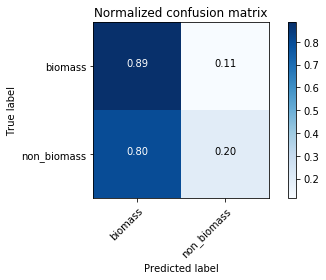

In [8]:
# Reset 
test_set.reset()

# Make predictions
predictions = model.predict_generator(test_set, steps=test_set.samples/test_set.batch_size, verbose=1)
normalised_predictions = np.argmax(predictions, axis=1)

# Print out scikit report
print(classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))

# Draw confusion matrix
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

#### Visualising Training History

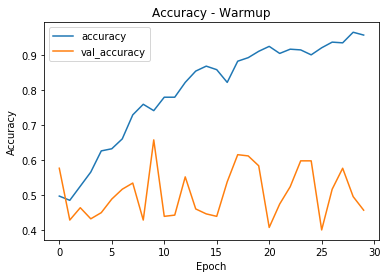

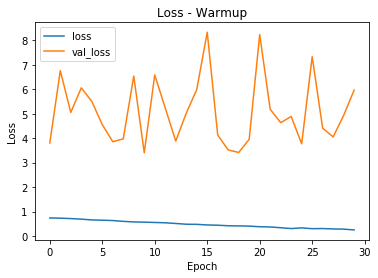

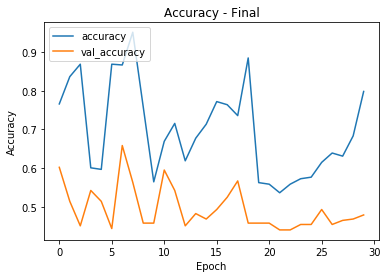

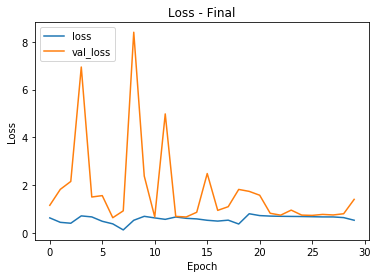

In [9]:
global_history = [warmup_history, final_history]

for history in global_history:
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title("Accuracy - " + history.plot_title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss - " + history.plot_title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [10]:
model.save('app\\trained_models\\Xception')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: app\trained_models\Xception\assets
